In [1]:
!pip uninstall tensorflow -y

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0


In [2]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pg-final-project-datasets/sample_submission.csv
/kaggle/input/pg-final-project-datasets/socialmedia-disaster-tweets-DFE.csv
/kaggle/input/pg-final-project-datasets/train.csv
/kaggle/input/pg-final-project-datasets/test.csv


In [6]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Dropout, Dense, Layer

2.15.0


In [5]:
!pip install text-hammer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [7]:
import gc
#import tensorflow as tf

tf.keras.backend.clear_session()
gc.collect()


0

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import text_hammer as th
from tqdm.notebook import tqdm
import pandas as pd
tqdm.pandas()
#import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from transformers import TFBertModel, AutoTokenizer
from sklearn.metrics import f1_score, accuracy_score

# Read Data

In [9]:
train_df = pd.read_csv('/kaggle/input/pg-final-project-datasets/train.csv',usecols=['id','text','target'])
test_df = pd.read_csv('/kaggle/input/pg-final-project-datasets/test.csv',usecols=['id','text'])
sample_df = pd.read_csv('/kaggle/input/pg-final-project-datasets/sample_submission.csv')

In [10]:
def text_preprocessing(train_df,text):
    
    train_df[text] = train_df[text].progress_apply(lambda x: str(x).lower())
    train_df[text] = train_df[text].progress_apply(lambda x: th.remove_emails(x))
    train_df[text] = train_df[text].progress_apply(lambda x: th.remove_html_tags(x))
    train_df[text] = train_df[text].progress_apply(lambda x: th.remove_special_chars(x))
    train_df[text] = train_df[text].progress_apply(lambda x: th.remove_accented_chars(x))
    return train_df


In [11]:
# Text preprocessing function
def text_preprocessing(test_df, text):
    column = text
    test_df[text] = test_df[text].progress_apply(lambda x: str(x).lower())
    test_df[text] = test_df[text].progress_apply(lambda x: th.remove_emails(x))
    test_df[text] = test_df[text].progress_apply(lambda x: th.remove_html_tags(x))
    test_df[text] = test_df[text].progress_apply(lambda x: th.remove_special_chars(x))
    test_df[text] = test_df[text].progress_apply(lambda x: th.remove_accented_chars(x))
    return test_df

In [12]:
# Clean the training and test data
train_cleaned_df = text_preprocessing(train_df, 'text')
test_cleaned_df = text_preprocessing(test_df, 'text')
train_df = train_cleaned_df.copy()
test_df = test_cleaned_df.copy()

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [13]:
from transformers import AutoTokenizer, TFBertModel

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
model = TFBertModel.from_pretrained('bert-large-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
# Tokenize the text data
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [15]:
# Prepare the labels
y_train = train_df.target.values

In [16]:
tokenizer('Hello good morning  i hope you are doing well  &*&*&&')

{'input_ids': [101, 7592, 2204, 2851, 1045, 3246, 2017, 2024, 2725, 2092, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
print("max len of tweets",max([len(x.split()) for x in train_df.text]))
max_length = 36

max len of tweets 31


In [18]:
y_train = train_df.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [19]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# Set the maximum sequence length
max_len = 36

# Define a custom Keras layer for BERT
class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # pooler_output

# Define input layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Get BERT embeddings
bert_output = BertLayer()([input_ids, input_mask])

# Add dropout and dense layers
out = Dropout(0.1)(bert_output)
out = Dense(128, activation='relu')(out)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

# Define the output layer
y = Dense(1, activation='sigmoid')(out)

# Create the model
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

# Setting the BERT layer as trainable
model.layers[2].trainable = True  # Adjusting the trainability of the BERT layers if needed

# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=6e-6,
    decay_steps=10000,  # Adjusting the number of decay steps based on our dataset size
    end_learning_rate=0
)

# Create the optimizer
optimizer = Adam(
    learning_rate=lr_schedule,
    epsilon=1e-8,
    clipnorm=1.0
)

# Compile the model 
loss = BinaryCrossentropy(from_logits=False)
metrics = [BinaryAccuracy()]

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

# the model summary and plotting the model
model.summary()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  1094822   ['input_ids[0][0]',           
                                                          40         'attention_mask[0][0]']      
                                                                                              

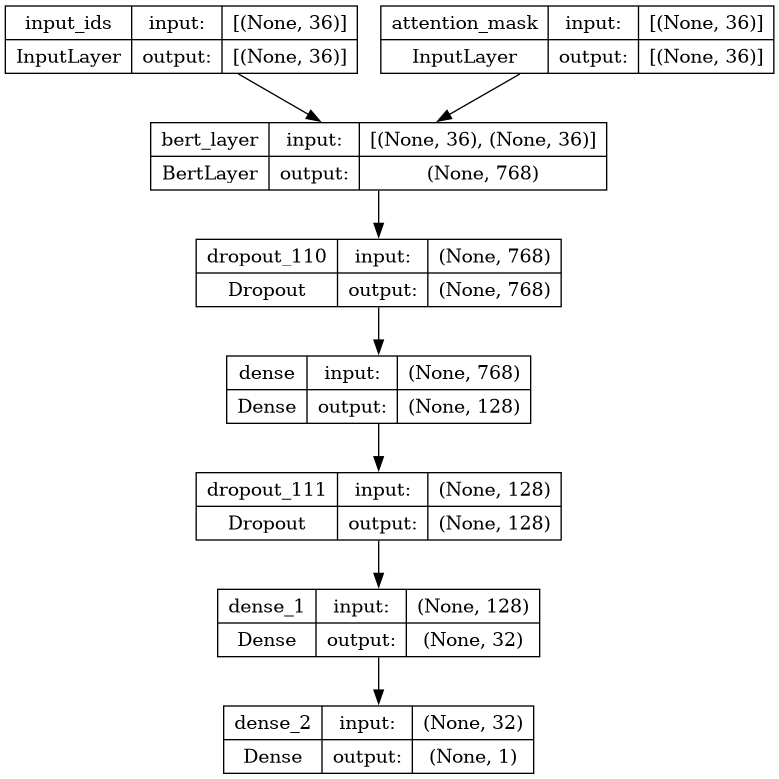

In [20]:
# plot_model(model, show_shapes=True)
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
# Training the model
train_history = model.fit(
    x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y=y_train,
    epochs=10,
    batch_size=10,
    validation_split=0.2  # Adding validation split for validation metrics
)

Epoch 1/10
609/609 [==============================] - 71s 117ms/step - loss: 0.0525 - binary_accuracy: 0.9801 - val_loss: 1.0323 - val_binary_accuracy: 0.8109
Epoch 2/10
609/609 [==============================] - 71s 117ms/step - loss: 0.0505 - binary_accuracy: 0.9811 - val_loss: 1.0471 - val_binary_accuracy: 0.8135
Epoch 3/10
609/609 [==============================] - 71s 116ms/step - loss: 0.0464 - binary_accuracy: 0.9833 - val_loss: 1.0443 - val_binary_accuracy: 0.8142
Epoch 4/10
609/609 [==============================] - 71s 116ms/step - loss: 0.0452 - binary_accuracy: 0.9823 - val_loss: 1.0526 - val_binary_accuracy: 0.8102
Epoch 5/10
609/609 [==============================] - 71s 116ms/step - loss: 0.0458 - binary_accuracy: 0.9842 - val_loss: 1.0526 - val_binary_accuracy: 0.8102
Epoch 6/10
609/609 [==============================] - 71s 116ms/step - loss: 0.0390 - binary_accuracy: 0.9837 - val_loss: 1.0526 - val_binary_accuracy: 0.8102
Epoch 7/10
609/609 [==========================

In [34]:
# Extract metrics from training history
accuracy_values = train_history.history['binary_accuracy']
val_accuracy_values = train_history.history.get('val_binary_accuracy')
loss_values = train_history.history['loss']
val_loss_values = train_history.history.get('val_loss')

print(accuracy_values)
print(val_accuracy_values)

[0.9801313877105713, 0.9811165928840637, 0.9832512140274048, 0.9822660088539124, 0.984236478805542, 0.9837438464164734, 0.984893262386322, 0.984893262386322, 0.984893262386322, 0.9847290515899658]
[0.810899555683136, 0.813525915145874, 0.8141825199127197, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903]


In [35]:
print(train_history.history)

{'loss': [0.05252803862094879, 0.0504719503223896, 0.046352218836545944, 0.04520004615187645, 0.04576914757490158, 0.039028748869895935, 0.03982071951031685, 0.04089224338531494, 0.04068160057067871, 0.040643349289894104], 'binary_accuracy': [0.9801313877105713, 0.9811165928840637, 0.9832512140274048, 0.9822660088539124, 0.984236478805542, 0.9837438464164734, 0.984893262386322, 0.984893262386322, 0.984893262386322, 0.9847290515899658], 'val_loss': [1.0323333740234375, 1.0470637083053589, 1.0442544221878052, 1.0525821447372437, 1.0525821447372437, 1.0525821447372437, 1.0525821447372437, 1.0525821447372437, 1.0525821447372437, 1.0525821447372437], 'val_binary_accuracy': [0.810899555683136, 0.813525915145874, 0.8141825199127197, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903, 0.8102429509162903]}


In [36]:
# Extract accuracy values from training history
accuracy_values = train_history.history['binary_accuracy']
val_accuracy_values = train_history.history.get('val_accuracy')  # Use .get() in case val_accuracy is not present

# Calculate average accuracy
average_accuracy = sum(accuracy_values) / len(accuracy_values)
average_val_accuracy = sum(val_accuracy_values) / len(val_accuracy_values) if val_accuracy_values else None

# Print average accuracies
print(f'Average training accuracy over {len(accuracy_values)} epochs: {average_accuracy:.4f}')
if average_val_accuracy is not None:
    print(f'Average validation accuracy over {len(val_accuracy_values)} epochs: {average_val_accuracy:.4f}')

Average training accuracy over 10 epochs: 0.9834


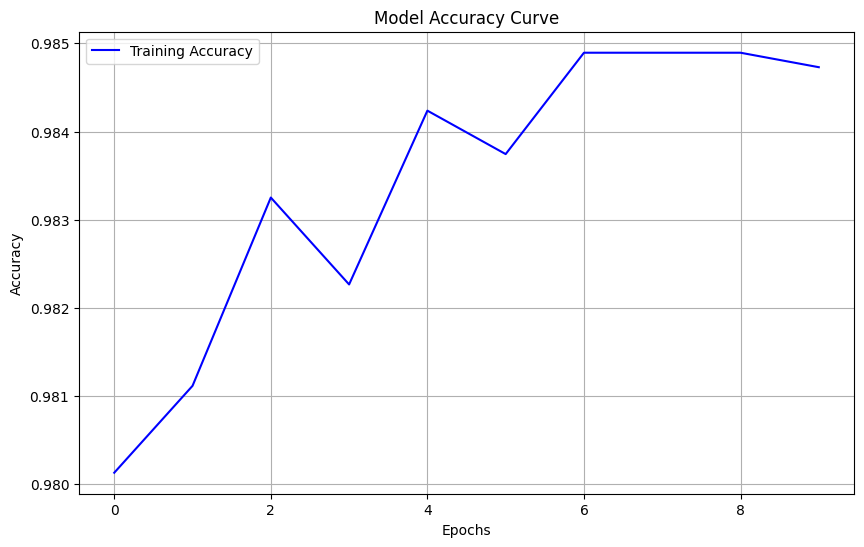

In [37]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(accuracy_values, 'b', label='Training Accuracy')
if val_accuracy_values:
    plt.plot(val_accuracy_values, 'r', label='Validation Accuracy')

plt.title('Model Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
# Predict on the training set
y_pred_train = model.predict({'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']})
y_pred_train = (y_pred_train > 0.5).astype(int)

238/238 [==============================] - 20s 84ms/step


In [39]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9537632996190727


238/238 [==============================] - 21s 86ms/step
Training Accuracy: 0.9537632996190727
Precision: 0.9506020376659463
Recall: 0.9413023540201774
F1-score: 0.9459293394777265


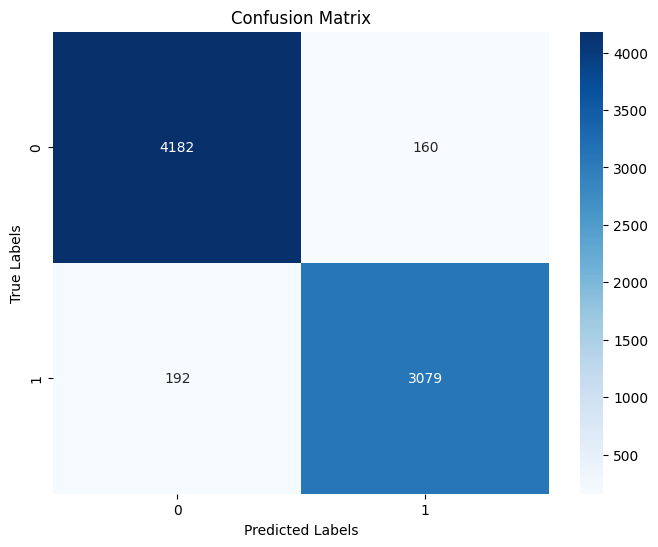

In [40]:
# Predict on the training set
y_pred_train = model.predict({'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']})
y_pred_train = (y_pred_train > 0.5).astype(int)

# Import necessary libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Calculate precision
precision = precision_score(y_train, y_pred_train)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_train, y_pred_train)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_train, y_pred_train)
print("F1-score:", f1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
